In [1]:
from datetime import datetime
import json
import os
import string
import warnings

from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
from utils import *

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_setup(experiment):
    return '_'.join(experiment.split('_')[2:])

In [3]:
experiment_names = [e.removesuffix('_conf.json') for e in os.listdir('experiments') if e.endswith('_conf.json')]
experiment_configs = []
experiment_results = []

for experiment in experiment_names:
    try:
        with open(f'experiments/{experiment}_conf.json', 'r') as f:
            conf = json.load(f)
            conf['experiment'] = experiment
            conf['setup'] = get_setup(experiment)
            experiment_configs.append(conf)
        
        experiment_result_files = os.listdir(f'experiments/results/{experiment}')
        
        for result_file in experiment_result_files:
            result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S')
            result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
            result['experiment'] = experiment
            result['modification_date'] = result_date
            experiment_results.append(result)
    except:
        print(f'Error reading experiment {experiment}')

experiment_configs = pd.DataFrame(experiment_configs)

experiment_results = pd.concat(experiment_results)
experiment_results = experiment_results.rename(columns={'success': 'optimizer_success', 'message': 'optimizer_message'})
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['num_2qub_gates'] = experiment_results['gate_sizes'].apply(lambda d: d['2']*2 + d.get('3',0)*4 + d.get('4',0)*6)
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['comp_max_population_int'] = experiment_results['state_populations'].apply(lambda s: np.argmax(s))
experiment_results['comp_max_population_bin'] = experiment_results.apply(lambda row: int_to_binary_str(row['comp_max_population_int'], row['nx']+row['ny']), axis=1)
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['success'] = experiment_results.apply(lambda row: row['comp_max_population_bin'] in row['solution'], axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)

Error reading experiment N35_p8_linear_quadratic
Error reading experiment N33_p9_linear_abs
Error reading experiment N533_p6_standard
Error reading experiment N533_p4_linear_quadratic
Error reading experiment N533_p3_linear_abs
Error reading experiment N533_p6_linear_quadratic
Error reading experiment N39_p9_linear_abs
Error reading experiment N533_p9_linear_abs
Error reading experiment N533_p4_standard
Error reading experiment N35_p9_linear_abs
Error reading experiment N533_p7_standard
Error reading experiment N533_p2_linear_abs
Error reading experiment N39_p8_linear_abs
Error reading experiment N533_p7_linear_quadratic
Error reading experiment N533_p3_linear_quadratic
Error reading experiment N533_p4_linear_abs
Error reading experiment N533_p8_linear_abs
Error reading experiment N533_p7_linear_abs
Error reading experiment N533_p2_linear_quadratic
Error reading experiment N533_p1_linear_abs
Error reading experiment N533_p5_standard
Error reading experiment N533_p6_linear_abs
Error rea

In [4]:
experiment_results_agg = (
    experiment_results
        .groupby('experiment')
        .agg({
            'num_qubits': 'first',
            'rep': 'count',
            'optimizer_steps': ['mean', 'median', 'std', 'max', 'min'],
            'num_gates': ['mean', 'median', 'std', 'max', 'min'],
            'num_2qub_gates': ['mean', 'median', 'std', 'max', 'min'],
            'cost': ['mean', 'median', 'std'],
            'success': ['mean', 'std', 'max', 'min'],
            'fidelity': ['mean', 'median', 'std', 'max', 'min'],
            'state_populations': lambda x: np.sum(x.tolist(), axis=0).tolist()
        })
    )

experiment_results_agg.columns = ['_'.join(map(str, col)) for col in experiment_results_agg.columns.to_flat_index()]
experiment_results_agg = experiment_results_agg.rename(columns={'num_qubits_first': 'num_qubits'})
experiment_results_agg = experiment_results_agg.rename(columns={'state_populations_<lambda>': 'populations'})

experiment_results_agg['populations_mean'] = experiment_results_agg.apply(lambda row: np.array(row['populations'])/row['rep_count'], axis=1)
experiment_results_agg = experiment_results_agg.drop(columns='populations')

experiment_results_agg['infidelity_mean'] = 1 - experiment_results_agg['fidelity_mean']
experiment_results_agg['infidelity_median'] = 1 - experiment_results_agg['fidelity_median']
experiment_results_agg['infidelity_min'] = 1 - experiment_results_agg['fidelity_max']
experiment_results_agg['infidelity_max'] = 1 - experiment_results_agg['fidelity_min']

experiments_df = pd.merge(experiment_configs, experiment_results_agg, how='inner', on='experiment')

if (experiments_df['num_gates_std'] != 0).any():
    print('Warning: There are experiments with inconsistent number of gates')

In [5]:
df_details = pd.merge(experiment_configs, experiment_results, how='inner', on='experiment')
df_details = df_details.drop(columns='layers_y')
df_details = df_details.rename(columns={'layers_x': 'layers'})

hist_data = df_details.groupby(['N', 'layers', 'setup'])['comp_max_population_bin'].value_counts().reset_index()

# Plots

In [6]:
lslist = ['-', (2, (2, 1)), (1, (3, 1, 1, 1)), (0, (3, 1)), (0, (1, 1)),'-', (2, (2, 1)), (1, (3, 1, 1, 1)), (0, (3, 1)), (0, (1, 1))]
Markers = ['o', "s", "D", "p", "v", "^", "X", "<", ">", "H","o", "s", "D", "p", "v", "^", "X", "<", ">", "H"]
leglist = [ 'N = 2', 'Dyn-1', 'Dyn-2', 'N = 5', 'N = 6', 'N = 7']

AxisParameters = 'width=5, length=10, labelsize=30'
AxisMinorParameters = 'width=1.2, length=4'

#Lines
linewidth = 4
markersize = 8
markeredgewidth=1.5
Labels_FontSize = 16
Box_width = 2
x_interval = 0.5
y_interval = 5.0
decimalFormart = '{x:.2f}'

#Style of the exp data points
DontShow = 0.0
DataPointSize = 9
skip = 8

#Error Bars style
e_line_width = 3
ending_size = 4
#colorList = plt.cm.jet(np.linspace(0,1,len(Power[0])))
Colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],     # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#0868ac", "#43a2ca"],  # Cian
    ["#006633", "#CCFFCC"],  # Green
    ["#cc4c02", "#fe9929"],  # Orange
    ["#91003f", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#b8860b", "#ffd700"],  # Golden
]

DataPoints = ["ms=DataPointSize, linewidth=0,markevery=8"]

csfont = {'fontname':'Times New Roman'}

legend_font = font_manager.FontProperties(math_fontfamily='cm', size=14)

## Settings

In [7]:
Ns = [15, 21, 33, 35]
save_plots = True

## Cost - Layers

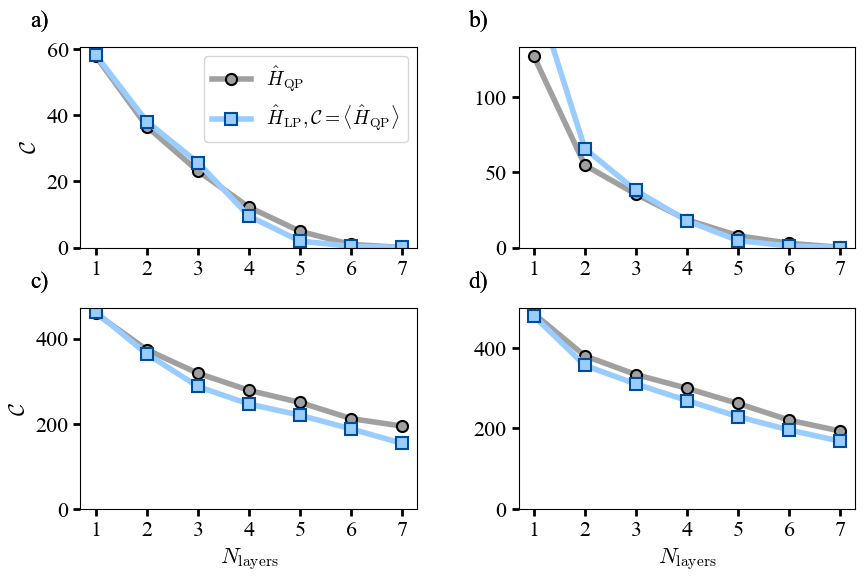

In [8]:
n_rows = int(len(Ns) / 2)

fig, axs = plt.subplots(n_rows, 2, figsize=(10,3*n_rows))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
    num_qubits = df.loc[0,'num_qubits']

    for j, setup in enumerate(['standard', 'linear_quadratic']):
        df_s = df[df['setup']==setup].copy()

        if setup=='standard':
            label = r"$\hat{H}_{\mathrm{QP}}$"
        elif setup=='linear_quadratic':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
        else:
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"

        axs[i].plot(
            'layers', 'cost_median', data=df_s, label=label, 
            linewidth=linewidth, markersize=markersize, marker=Markers[j], color=Colors[j][1],
            mec=Colors[j][0], mfc=Colors[j][1], markeredgewidth=markeredgewidth)
        
        axs[i].set_ylim(0)
        
        axs[i].text(-0.15, 1.1, f'{string.ascii_lowercase[i]})', transform=axs[i].transAxes, fontsize=Labels_FontSize+1, **csfont)

    if i%2==0:
        axs[i].set_ylabel(r"$\mathcal{C}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
    if i >= len(Ns)-2:
        axs[i].set_xlabel(r"$N_\mathrm{layers}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
    
    axs[i].set_ylim(0)
    axs[i].xaxis.set_major_locator(MultipleLocator(1))

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())
    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
    axs[i].yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize)
    axs[i].tick_params(axis='y', which='minor', width = Box_width, length=4)
    axs[i].tick_params(axis='x', which='minor', width = Box_width, length=4)
    
axs[0].legend(prop=legend_font, loc='best')

if save_plots:
    N_str = [str(x) for x in Ns]
    fig_name = f'plots/Cost_Layers_N={"-".join(N_str)}.pdf'
    plt.savefig(fig_name, bbox_inches='tight')

## Cost - N2quG

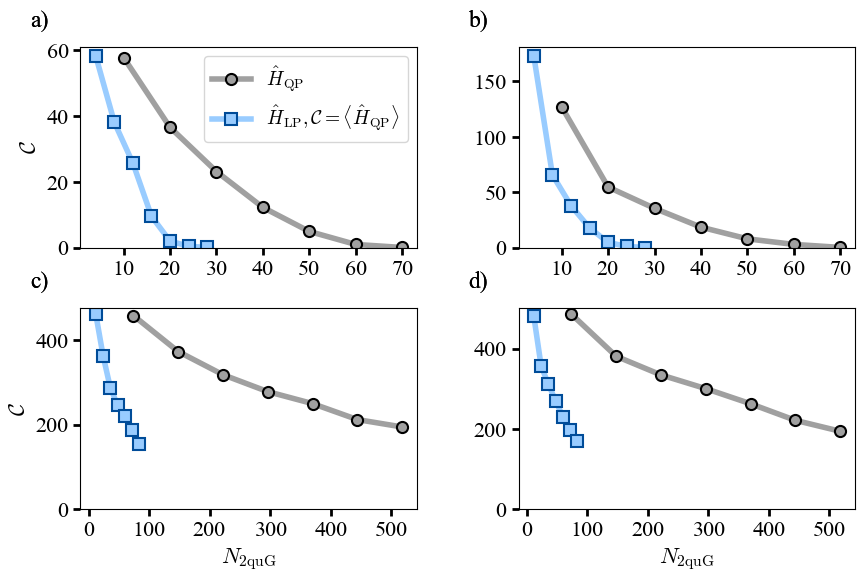

In [9]:
n_rows = int(len(Ns) / 2)

fig, axs = plt.subplots(n_rows, 2, figsize=(10,3*n_rows))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
    num_qubits = df.loc[0,'num_qubits']

    for j, setup in enumerate(['standard', 'linear_quadratic']):
        df_s = df[df['setup']==setup].copy()

        if setup=='standard':
            label = r"$\hat{H}_{\mathrm{QP}}$"
        elif setup=='linear_quadratic':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
        else:
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"

        axs[i].plot(
            'num_2qub_gates_max', 'cost_median', data=df_s, label=label, 
            linewidth=linewidth, markersize=markersize, marker=Markers[j], color=Colors[j][1],
            mec=Colors[j][0], mfc=Colors[j][1], markeredgewidth=markeredgewidth)
        
        axs[i].text(-0.15, 1.1, f'{string.ascii_lowercase[i]})', transform=axs[i].transAxes, fontsize=Labels_FontSize+1, **csfont)


    if i%2==0:
        axs[i].set_ylabel(r"$\mathcal{C}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
    if i >= len(Ns)-2:
        axs[i].set_xlabel(r"$N_\mathrm{2quG}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont);
    
    axs[i].set_ylim(0)
    axs[i].xaxis.set_major_locator(MultipleLocator(10 if num_qubits==3 else 100))

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())
    
    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
    axs[i].yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize)
    axs[i].tick_params(axis='y', which='minor', width = Box_width, length=4)
    axs[i].tick_params(axis='x', which='minor', width = Box_width, length=4)
    
axs[0].legend(prop=legend_font, loc='best')

if save_plots:
    N_str = [str(x) for x in Ns]
    fig_name = f'plots/Cost_Gates_N={"-".join(N_str)}.pdf'
    plt.savefig(fig_name, bbox_inches='tight')

## State Populations

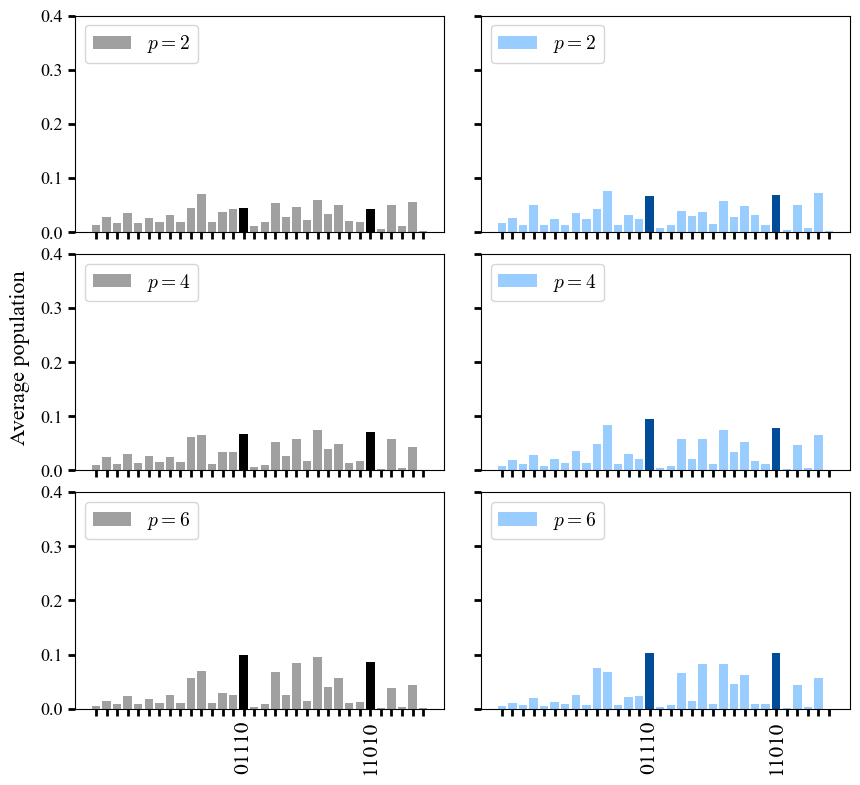

In [10]:
N = 35
layers = [2,4,6]

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']
solutions = compute_solution(N)

x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

n_rows = len(layers)
fig, axs = plt.subplots(n_rows, 2, figsize=(10,3*n_rows), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, p in enumerate(layers):
    for j, setup in enumerate(['standard', 'linear_quadratic']):
        populations = df[(df['setup']==setup) & (df['layers']==p)].reset_index().loc[0, 'populations_mean']

        if setup=='standard':
            label = r"$\hat{H}_{\mathrm{QP}}$"
        elif setup=='linear_quadratic':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
        else:
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"

        bar_colors = [Colors[j][0] if c in solutions else Colors[j][1] for c in x_hist]

        axs[i][j].bar(x_hist, populations, label=f'$p={p}$', color=bar_colors)
        axs[i][j].set_ylim(0,1 if num_qubits <=3 else 0.4)

        labels = (axs[i][j].get_xticklabels() + axs[i][j].get_yticklabels())

        for label in labels:
            label.set_fontname('Times New Roman')

        axs[i][j].legend(prop=legend_font, loc='upper left')
        axs[i][j].xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
        axs[i][j].yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize-3)

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90)

    if num_qubits >= 5:
        for i, label in enumerate(ax.get_xticklabels()):
            label.set_visible(label.get_text() in solutions)
    

fig.text(0.06, 0.5, 'Average population', va='center', rotation='vertical', fontsize=Labels_FontSize, fontname='Times New Roman')

if save_plots:
    plt.savefig(f'plots/Populations_N={N}.pdf', bbox_inches='tight')

## Cost - Layers (with abs)

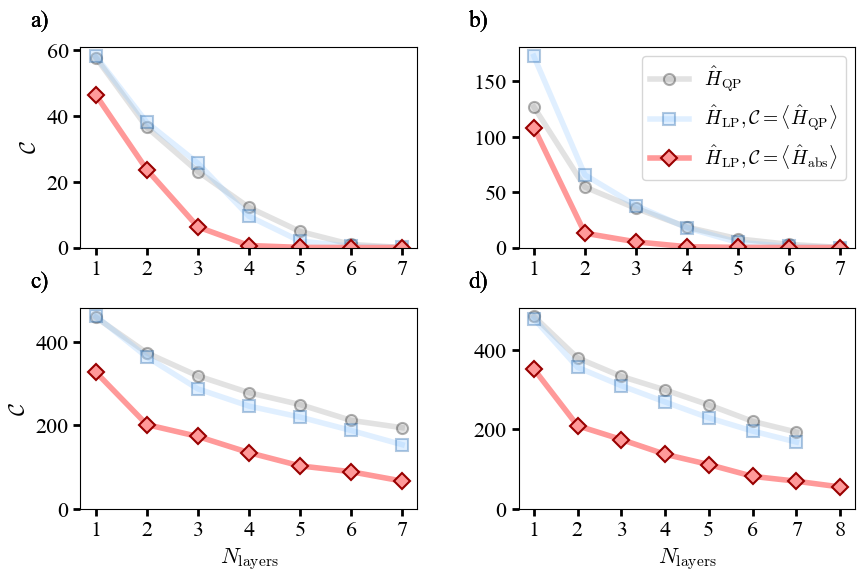

In [11]:
n_rows = int(len(Ns) / 2)

fig, axs = plt.subplots(n_rows, 2, figsize=(10,3*n_rows))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
    num_qubits = df.loc[0,'num_qubits']

    for j, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        df_s = df[df['setup']==setup].copy()

        if setup=='standard':
            label = r"$\hat{H}_{\mathrm{QP}}$"
        elif setup=='linear_quadratic':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
        elif setup=='linear_abs':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"
            df_s['cost_mean'] = df_s['cost_mean']**2
            df_s['cost_median'] = df_s['cost_median']**2

        axs[i].plot(
            'layers', 'cost_median', data=df_s, label=label, 
            linewidth=linewidth, markersize=markersize, marker=Markers[j], color=Colors[j][1],
            mec=Colors[j][0], mfc=Colors[j][1], markeredgewidth=markeredgewidth, alpha=0.3 if setup!='linear_abs' else 1)
        
        axs[i].text(-0.15, 1.1, f'{string.ascii_lowercase[i]})', transform=axs[i].transAxes, fontsize=Labels_FontSize+1, **csfont)

    if i%2==0:
        axs[i].set_ylabel(r"$\mathcal{C}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
    if i >= len(Ns)-2:
        axs[i].set_xlabel(r"$N_\mathrm{layers}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
    
    axs[i].set_ylim(0)
    axs[i].xaxis.set_major_locator(MultipleLocator(1))

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())
    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
    axs[i].yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize)
    axs[i].tick_params(axis='y', which='minor', width = Box_width, length=4)
    axs[i].tick_params(axis='x', which='minor', width = Box_width, length=4)
    
axs[1].legend(prop=legend_font, loc='best')

if save_plots:
    N_str = [str(x) for x in Ns]
    fig_name = f'plots/Cost_Layers_Abs_N={"-".join(N_str)}.pdf'
    plt.savefig(fig_name, bbox_inches='tight')

## Cost - Gates (abs)

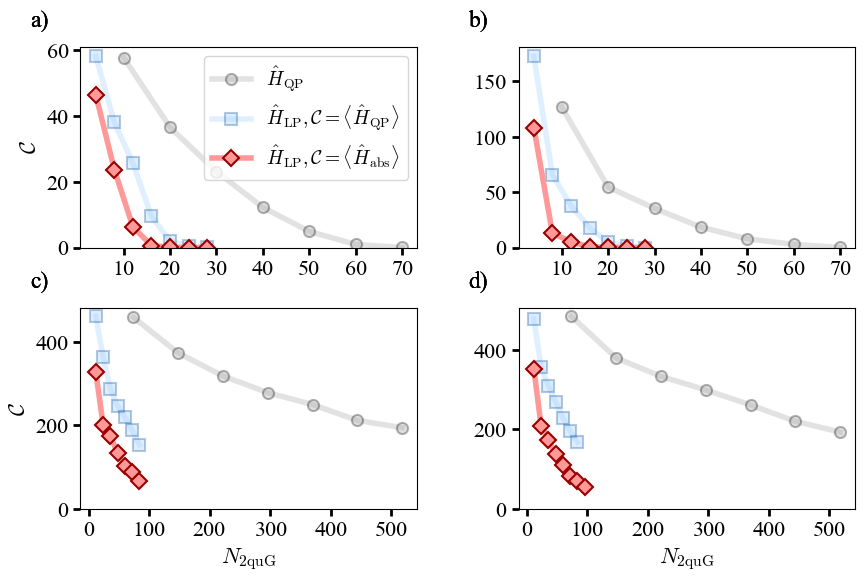

In [12]:
n_rows = int(len(Ns) / 2)

fig, axs = plt.subplots(n_rows, 2, figsize=(10,3*n_rows))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
    num_qubits = df.loc[0,'num_qubits']

    for j, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        df_s = df[df['setup']==setup].copy()

        if setup=='standard':
            label = r"$\hat{H}_{\mathrm{QP}}$"
        elif setup=='linear_quadratic':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
        else:
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"
            df_s['cost_mean'] = df_s['cost_mean']**2
            df_s['cost_median'] = df_s['cost_median']**2

        axs[i].plot(
            'num_2qub_gates_max', 'cost_median', data=df_s, label=label, 
            linewidth=linewidth, markersize=markersize, marker=Markers[j], color=Colors[j][1],
            mec=Colors[j][0], mfc=Colors[j][1], markeredgewidth=markeredgewidth, alpha=0.3 if setup!='linear_abs' else 1)
        
        axs[i].text(-0.15, 1.1, f'{string.ascii_lowercase[i]})', transform=axs[i].transAxes, fontsize=Labels_FontSize+1, **csfont)


    if i%2==0:
        axs[i].set_ylabel(r"$\mathcal{C}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
    if i >= len(Ns)-2:
        axs[i].set_xlabel(r"$N_\mathrm{2quG}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont);
    
    axs[i].set_ylim(0)
    axs[i].xaxis.set_major_locator(MultipleLocator(10 if num_qubits==3 else 100))

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())
    
    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
    axs[i].yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize)
    axs[i].tick_params(axis='y', which='minor', width = Box_width, length=4)
    axs[i].tick_params(axis='x', which='minor', width = Box_width, length=4)
    
axs[0].legend(prop=legend_font, loc='best')

if save_plots:
    N_str = [str(x) for x in Ns]
    fig_name = f'plots/Cost_Gates_Abs_N={"-".join(N_str)}.pdf'
    plt.savefig(fig_name, bbox_inches='tight')

## Fidelity

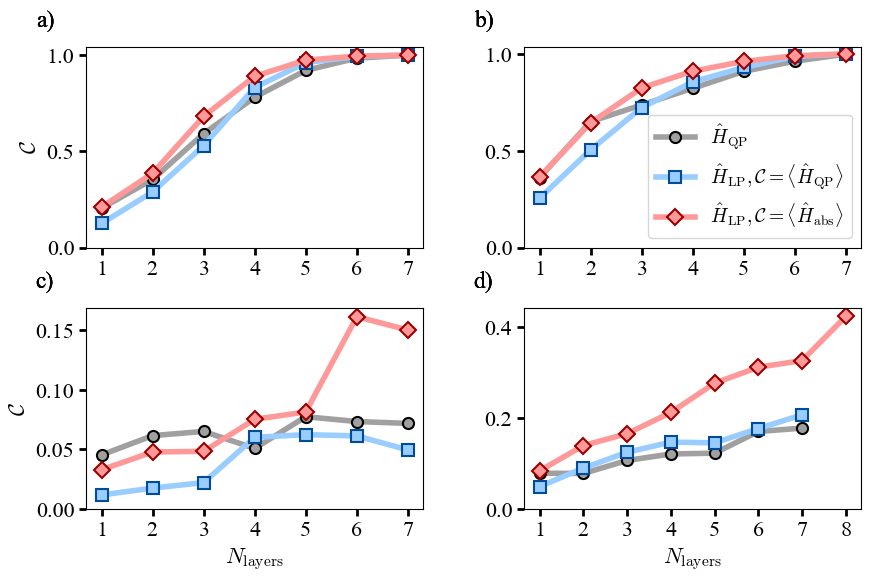

In [13]:
n_rows = int(len(Ns) / 2)

fig, axs = plt.subplots(n_rows, 2, figsize=(10,3*n_rows))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
    num_qubits = df.loc[0,'num_qubits']

    for j, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        df_s = df[df['setup']==setup].copy()

        if setup=='standard':
            label = r"$\hat{H}_{\mathrm{QP}}$"
        elif setup=='linear_quadratic':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
        elif setup=='linear_abs':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"
            df_s['cost_mean'] = df_s['cost_mean']**2
            df_s['cost_median'] = df_s['cost_median']**2

        axs[i].plot(
            'layers', 'fidelity_median', data=df_s, label=label, 
            linewidth=linewidth, markersize=markersize, marker=Markers[j], color=Colors[j][1],
            mec=Colors[j][0], mfc=Colors[j][1], markeredgewidth=markeredgewidth)#), alpha=0.3 if setup!='linear_abs' else 1)
        
        axs[i].text(-0.15, 1.1, f'{string.ascii_lowercase[i]})', transform=axs[i].transAxes, fontsize=Labels_FontSize+1, **csfont)

    if i%2==0:
        axs[i].set_ylabel(r"$\mathcal{C}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
    if i >= len(Ns)-2:
        axs[i].set_xlabel(r"$N_\mathrm{layers}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
    
    axs[i].set_ylim(0)
    axs[i].xaxis.set_major_locator(MultipleLocator(1))

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())
    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
    axs[i].yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize)
    axs[i].tick_params(axis='y', which='minor', width = Box_width, length=4)
    axs[i].tick_params(axis='x', which='minor', width = Box_width, length=4)
    
axs[1].legend(prop=legend_font, loc='best')

if save_plots:
    N_str = [str(x) for x in Ns]
    fig_name = f'plots/Cost_Layers_Abs_N={"-".join(N_str)}.pdf'
    plt.savefig(fig_name, bbox_inches='tight')

## Success (Mode)

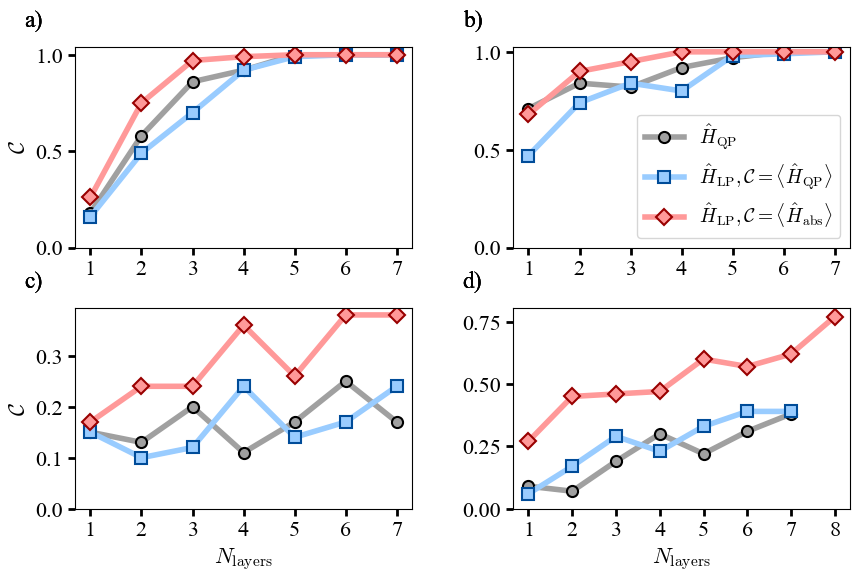

In [14]:
n_rows = int(len(Ns) / 2)

fig, axs = plt.subplots(n_rows, 2, figsize=(10,3*n_rows))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
    num_qubits = df.loc[0,'num_qubits']

    for j, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        df_s = df[df['setup']==setup].copy()

        if setup=='standard':
            label = r"$\hat{H}_{\mathrm{QP}}$"
        elif setup=='linear_quadratic':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
        elif setup=='linear_abs':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"
            df_s['cost_mean'] = df_s['cost_mean']**2
            df_s['cost_median'] = df_s['cost_median']**2

        axs[i].plot(
            'layers', 'success_mean', data=df_s, label=label, 
            linewidth=linewidth, markersize=markersize, marker=Markers[j], color=Colors[j][1],
            mec=Colors[j][0], mfc=Colors[j][1], markeredgewidth=markeredgewidth)#), alpha=0.3 if setup!='linear_abs' else 1)
        
        axs[i].text(-0.15, 1.1, f'{string.ascii_lowercase[i]})', transform=axs[i].transAxes, fontsize=Labels_FontSize+1, **csfont)

    if i%2==0:
        axs[i].set_ylabel(r"$\mathcal{C}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
    if i >= len(Ns)-2:
        axs[i].set_xlabel(r"$N_\mathrm{layers}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
    
    axs[i].set_ylim(0)
    axs[i].xaxis.set_major_locator(MultipleLocator(1))

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())
    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
    axs[i].yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize)
    axs[i].tick_params(axis='y', which='minor', width = Box_width, length=4)
    axs[i].tick_params(axis='x', which='minor', width = Box_width, length=4)
    
axs[1].legend(prop=legend_font, loc='best')

if save_plots:
    N_str = [str(x) for x in Ns]
    fig_name = f'plots/Cost_Layers_Abs_N={"-".join(N_str)}.pdf'
    plt.savefig(fig_name, bbox_inches='tight')

## Single plots

In [29]:
N = 35

### Cost-Layers

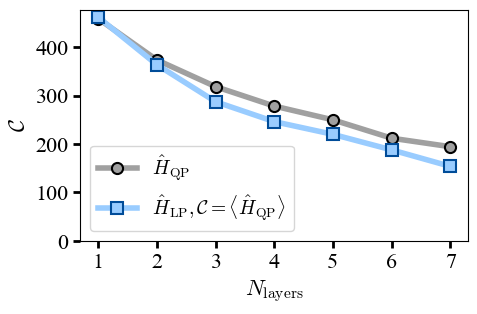

In [23]:
fig, ax = plt.subplots(figsize=(5,3))

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']

for j, setup in enumerate(['standard', 'linear_quadratic']):
    df_s = df[df['setup']==setup].copy()

    if setup=='standard':
        label = r"$\hat{H}_{\mathrm{QP}}$"
    elif setup=='linear_quadratic':
        label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
    else:
        label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"

    ax.plot(
        'layers', 'cost_median', data=df_s, label=label, 
        linewidth=linewidth, markersize=markersize, marker=Markers[j], color=Colors[j][1],
        mec=Colors[j][0], mfc=Colors[j][1], markeredgewidth=markeredgewidth)

ax.set_ylabel(r"$\mathcal{C}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
ax.set_xlabel(r"$N_\mathrm{layers}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
ax.xaxis.set_major_locator(MultipleLocator(1))

labels = (ax.get_xticklabels() + ax.get_yticklabels())
for label in labels:
    label.set_fontname('Times New Roman')

ax.xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
ax.yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize)
ax.tick_params(axis='y', which='minor', width = Box_width, length=4)
ax.tick_params(axis='x', which='minor', width = Box_width, length=4)
ax.set_ylim(0)

ax.legend(prop=legend_font, loc='best')

if save_plots:
    fig_name = f'plots/Cost_Layers_N={N}.pdf'
    plt.savefig(fig_name, bbox_inches='tight')

### Cost-Gates

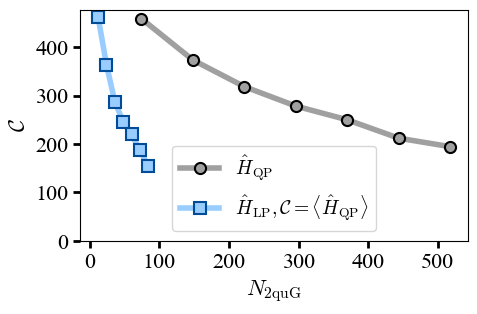

In [24]:
fig, ax = plt.subplots(figsize=(5,3))

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']

for j, setup in enumerate(['standard', 'linear_quadratic']):
    df_s = df[df['setup']==setup].copy()

    if setup=='standard':
        label = r"$\hat{H}_{\mathrm{QP}}$"
    elif setup=='linear_quadratic':
        label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
    else:
        label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"

    ax.plot(
        'num_2qub_gates_max', 'cost_median', data=df_s, label=label, 
        linewidth=linewidth, markersize=markersize, marker=Markers[j], color=Colors[j][1],
        mec=Colors[j][0], mfc=Colors[j][1], markeredgewidth=markeredgewidth)

ax.set_ylabel(r"$\mathcal{C}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
ax.set_xlabel(r"$N_\mathrm{2quG}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
ax.xaxis.set_major_locator(MultipleLocator(1))

labels = (ax.get_xticklabels() + ax.get_yticklabels())
for label in labels:
    label.set_fontname('Times New Roman')

ax.xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
ax.xaxis.set_major_locator(MultipleLocator(10 if num_qubits==3 else 100))
ax.yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize)
ax.tick_params(axis='y', which='minor', width = Box_width, length=4)
ax.tick_params(axis='x', which='minor', width = Box_width, length=4)
ax.set_ylim(0)

ax.legend(prop=legend_font, loc='best')

if save_plots:
    fig_name = f'plots/Cost_Gates_N={N}.pdf'
    plt.savefig(fig_name, bbox_inches='tight')

### Cost-Layers (abs)

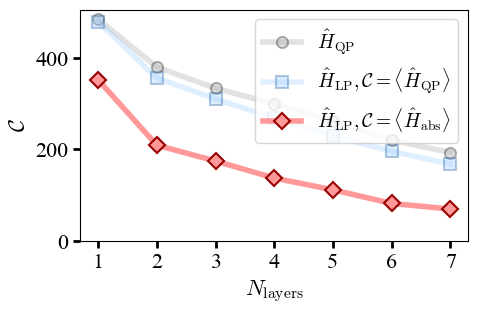

In [32]:
fig, ax = plt.subplots(figsize=(5,3))

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']

for j, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
    df_s = df[df['setup']==setup].copy()
    df_s = df_s[df_s['layers'] <= 7]

    if setup=='standard':
        label = r"$\hat{H}_{\mathrm{QP}}$"
    elif setup=='linear_quadratic':
        label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
    else:
        label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"
        df_s['cost_mean'] = df_s['cost_mean']**2
        df_s['cost_median'] = df_s['cost_median']**2

    ax.plot(
        'layers', 'cost_median', data=df_s, label=label, 
        linewidth=linewidth, markersize=markersize, marker=Markers[j], color=Colors[j][1],
        mec=Colors[j][0], mfc=Colors[j][1], markeredgewidth=markeredgewidth, alpha=0.3 if setup!='linear_abs' else 1)

ax.set_ylabel(r"$\mathcal{C}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
ax.set_xlabel(r"$N_\mathrm{layers}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
ax.xaxis.set_major_locator(MultipleLocator(1))

labels = (ax.get_xticklabels() + ax.get_yticklabels())
for label in labels:
    label.set_fontname('Times New Roman')

ax.xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
ax.yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize)
ax.tick_params(axis='y', which='minor', width = Box_width, length=4)
ax.tick_params(axis='x', which='minor', width = Box_width, length=4)
ax.set_ylim(0)

ax.legend(prop=legend_font, loc='best')

if save_plots:
    fig_name = f'plots/Cost_Layers_Abs_N={N}.pdf'
    plt.savefig(fig_name, bbox_inches='tight')

### Cost-Gates (abs)

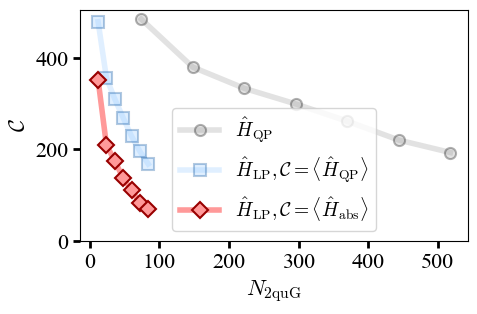

In [33]:
fig, ax = plt.subplots(figsize=(5,3))

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']

for j, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
    df_s = df[df['setup']==setup].copy()
    df_s = df_s[df_s['layers'] <= 7]

    if setup=='standard':
        label = r"$\hat{H}_{\mathrm{QP}}$"
    elif setup=='linear_quadratic':
        label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
    else:
        label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"
        df_s['cost_mean'] = df_s['cost_mean']**2
        df_s['cost_median'] = df_s['cost_median']**2

    ax.plot(
        'num_2qub_gates_max', 'cost_median', data=df_s, label=label, 
        linewidth=linewidth, markersize=markersize, marker=Markers[j], color=Colors[j][1],
        mec=Colors[j][0], mfc=Colors[j][1], markeredgewidth=markeredgewidth, alpha=0.3 if setup!='linear_abs' else 1)

ax.set_ylabel(r"$\mathcal{C}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
ax.set_xlabel(r"$N_\mathrm{2quG}$", fontsize = Labels_FontSize, math_fontfamily='cm', **csfont)
ax.xaxis.set_major_locator(MultipleLocator(1))

labels = (ax.get_xticklabels() + ax.get_yticklabels())
for label in labels:
    label.set_fontname('Times New Roman')

ax.xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
ax.xaxis.set_major_locator(MultipleLocator(10 if num_qubits==3 else 100))
ax.yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize)
ax.tick_params(axis='y', which='minor', width = Box_width, length=4)
ax.tick_params(axis='x', which='minor', width = Box_width, length=4)
ax.set_ylim(0)

ax.legend(prop=legend_font, loc='best')

if save_plots:
    fig_name = f'plots/Cost_Gates_Abs_N={N}.pdf'
    plt.savefig(fig_name, bbox_inches='tight')

### Populations Variant

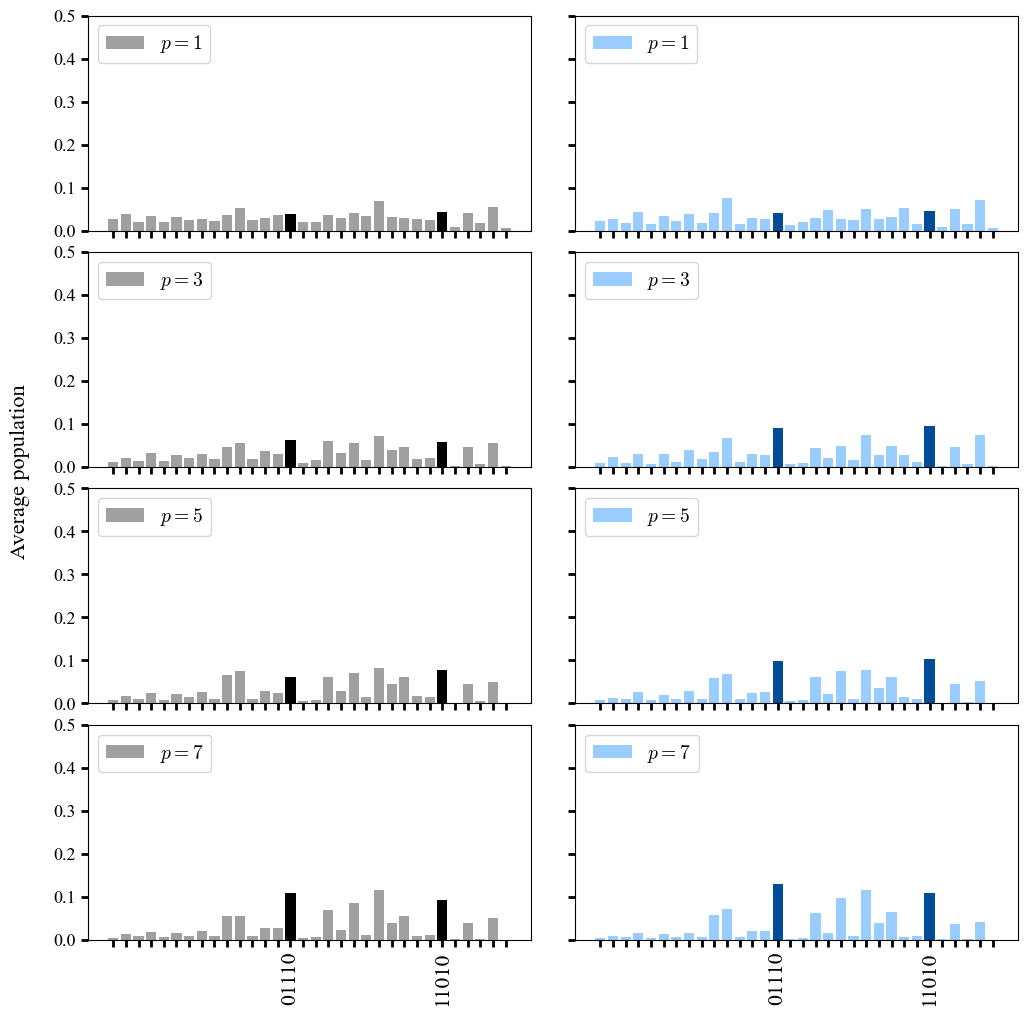

In [20]:
layers = [1,3,5,7]

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']
solutions = compute_solution(N)

x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

n_rows = len(layers)
fig, axs = plt.subplots(n_rows, 2, figsize=(12,3*n_rows), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, p in enumerate(layers):
    for j, setup in enumerate(['standard', 'linear_quadratic']):
        populations = df[(df['setup']==setup) & (df['layers']==p)].reset_index().loc[0, 'populations_mean']

        if setup=='standard':
            label = r"$\hat{H}_{\mathrm{QP}}$"
        elif setup=='linear_quadratic':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
        else:
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"

        bar_colors = [Colors[j][0] if c in solutions else Colors[j][1] for c in x_hist]

        axs[i][j].bar(x_hist, populations, label=f'$p={p}$', color=bar_colors)
        axs[i][j].set_ylim(0,1 if num_qubits <=3 else 0.5)

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90)

    if num_qubits >= 5:
        for i, label in enumerate(ax.get_xticklabels()):
            label.set_visible(label.get_text() in solutions)
    

fig.text(0.06, 0.5, 'Average population', va='center', rotation='vertical', fontsize=Labels_FontSize, fontname='Times New Roman')

for ax in axs.flatten():
    labels = (ax.get_xticklabels() + ax.get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    ax.legend(prop=legend_font, loc='upper left')
    ax.xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
    ax.yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize-3)

if save_plots:
    plt.savefig(f'plots/Populations_Var_N={N}.pdf', bbox_inches='tight')

### Populations with Abs

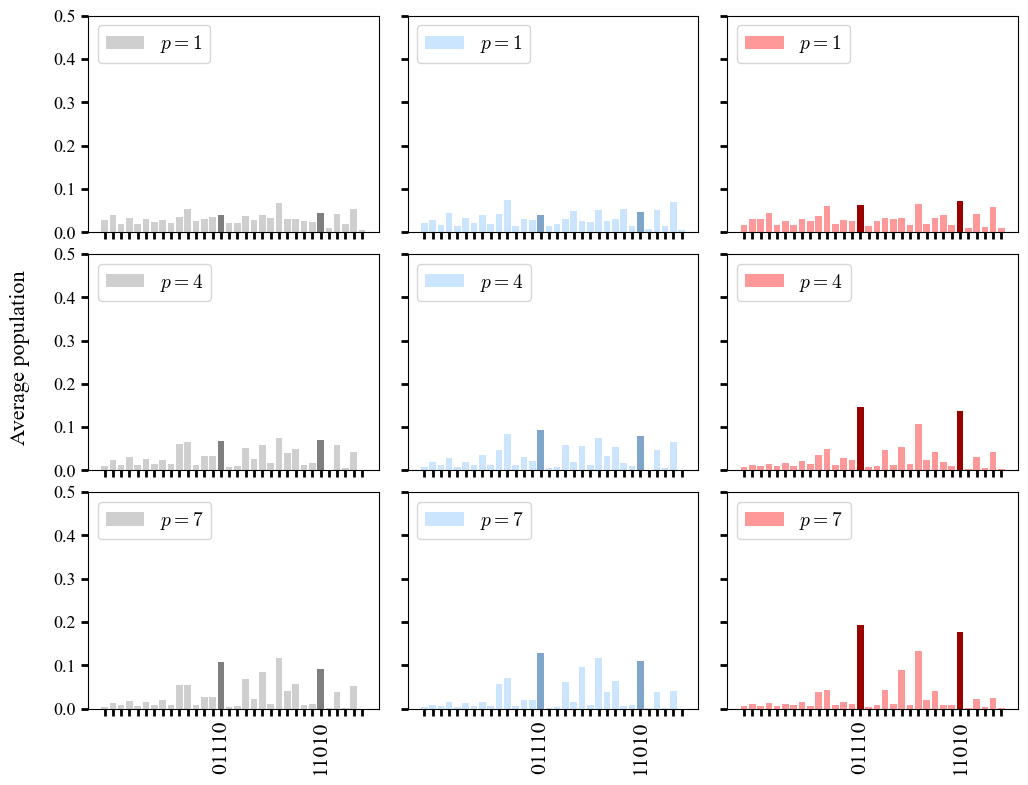

In [21]:
N = 35

layers = [1,4,7]

df = experiments_df[experiments_df['number'] == N].sort_values(by=['setup', 'layers']).reset_index()
num_qubits = df.loc[0,'num_qubits']
solutions = compute_solution(N)

x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

n_rows = len(layers)
fig, axs = plt.subplots(n_rows, 3, figsize=(12,3*n_rows), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, p in enumerate(layers):
    for j, setup in enumerate(['standard', 'linear_quadratic', 'linear_abs']):
        populations = df[(df['setup']==setup) & (df['layers']==p)].reset_index().loc[0, 'populations_mean']

        if setup=='standard':
            label = r"$\hat{H}_{\mathrm{QP}}$"
        elif setup=='linear_quadratic':
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{QP}} \rangle$"
        else:
            label = r"$\hat{H}_{\mathrm{LP}}, \mathcal{C}=\langle \hat{H}_{\mathrm{abs}} \rangle$"

        bar_colors = [Colors[j][0] if c in solutions else Colors[j][1] for c in x_hist]

        axs[i][j].bar(x_hist, populations, label=f'$p={p}$', color=bar_colors, alpha=0.5 if setup!='linear_abs' else 1)
        axs[i][j].set_ylim(0,1 if num_qubits <=3 else 0.5)

for ax in axs[-1]:
    ax.set_xticks(range(2**num_qubits))
    ax.set_xticklabels(x_hist, rotation=90)

    if num_qubits >= 5:
        for i, label in enumerate(ax.get_xticklabels()):
            label.set_visible(label.get_text() in solutions)
    

fig.text(0.06, 0.5, 'Average population', va='center', rotation='vertical', fontsize=Labels_FontSize, fontname='Times New Roman')

for ax in axs.flatten():
    labels = (ax.get_xticklabels() + ax.get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    ax.legend(prop=legend_font, loc='upper left')
    ax.xaxis.set_tick_params(width=Box_width, length=5, labelsize=Labels_FontSize)
    ax.yaxis.set_tick_params(width=Box_width, length=5, labelsize = Labels_FontSize-3)

if save_plots:
    plt.savefig(f'plots/Populations_Abs_N={N}.pdf', bbox_inches='tight')